In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#multimodele finale entrainé sur le train complet

chargement du train fusioné CNN BERT à la volée, pour une question de mémoire RAM, il ne nous a pas été possible d'enregistrer un dataset tensorflow, nous le recréons à la volée.
Pour le trtestain et le val, nous avons pu enregistrer sur le drive.

In [ ]:
import os
import tensorflow as tf

save_dir_bert = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/BERT2/'
train_dataset_bert_path = os.path.join(save_dir_bert, 'train_tf_dataset')
train_dataset_bert = tf.data.Dataset.load(train_dataset_bert_path).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tqdm import tqdm

def create_image_id_mapping_bert(dataset):
    dataset_dict = {}
    total = tf.data.experimental.cardinality(dataset).numpy()
    if total == tf.data.experimental.INFINITE_CARDINALITY:
        total = None

    # Ajouter la barre de progression tqdm
    for inputs, label in tqdm(dataset, total=total, desc='Création du mapping image_ID pour BERT'):
        # Les labels sont scalaires, pas de dimension de batch
        image_ID = inputs['image_ID'].numpy().decode('utf-8')
        data = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
        }
        dataset_dict[image_ID] = (data, label)
    return dataset_dict


In [ ]:
def merge_datasets(bert_dict, cnn_dict):
    merged_data = []
    for image_ID in bert_dict.keys():
        if image_ID in cnn_dict:
            bert_data, bert_label = bert_dict[image_ID]
            cnn_data, cnn_label = cnn_dict[image_ID]

            # Vérifier que les labels sont identiques
            if bert_label != cnn_label:
                print(f"Avertissement : labels différents pour image_ID {image_ID}")

            merged_inputs = {
                'input_ids': bert_data['input_ids'],
                'attention_mask': bert_data['attention_mask'],
                'image': cnn_data['image'],
                'image_ID': image_ID,
            }
            label = bert_label  # On peut choisir l'un ou l'autre, ils devraient être identiques

            merged_data.append((merged_inputs, label))
    return merged_data


In [ ]:
def create_tf_dataset_from_merged_data(merged_data):
    def generator():
        for inputs, label in merged_data:
            yield inputs, label

    output_signature = (
        {
            'input_ids': tf.TensorSpec(shape=(512,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(512,), dtype=tf.int32),
            'image': tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),
            'image_ID': tf.TensorSpec(shape=(), dtype=tf.string),
        },
        tf.TensorSpec(shape=(), dtype=tf.int64)  # Label en dehors des inputs
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset

In [ ]:
import pickle

# Fonction pour sauvegarder le dictionnaire
def save_dataset_dict_pickle(dataset_dict, filename):
    with open(filename, 'wb') as handle:
        pickle.dump(dataset_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Fonction pour charger le dictionnaire
def load_dataset_dict_pickle(filename):
    with open(filename, 'rb') as handle:
        dataset_dict = pickle.load(handle)
    return dataset_dict


nous regroupons les features CNN et BERT dans un même dataset tensorflow.
Les features CNN on été enregistré dans un dictionnaire, sauvé au format pkl

In [ ]:
save_dir_merged = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/'
train_dataset_cnn_dict_path = os.path.join(save_dir_merged, 'train_dataset_cnn_dict2.pkl')
train_dataset_cnn_dict = load_dataset_dict_pickle(train_dataset_cnn_dict_path)

train_dataset_bert_dict = create_image_id_mapping_bert(train_dataset_bert)
# train_dataset_bert_dict_path = os.path.join(save_dir_merged, 'train_dataset_bert_dict2.pkl')
# save_dataset_dict_pickle(train_dataset_bert_dict, train_dataset_bert_dict_path)
# Fusion des datasets
merged_train_data = merge_datasets(train_dataset_bert_dict, train_dataset_cnn_dict)

# Création du dataset final
final_train_dataset = create_tf_dataset_from_merged_data(merged_train_data)



Création du mapping image_ID pour BERT: 100%|██████████| 320000/320000 [01:45<00:00, 3041.24it/s]


Modéliisation multimodel BERT CNN

In [14]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertConfig
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import os
from keras.saving import register_keras_serializable
import numpy as np
from tensorflow.keras import regularizers


# ------------------------------------------------------------------------------
# 1. Configuration Initiale
# ------------------------------------------------------------------------------
print("Num GPUs Available (TensorFlow): ", len(tf.config.list_physical_devices('GPU')))

# Chemins des modèles et des datasets
drive_model_BERT_dir = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/saved_BERTmodel_tensorflow_01/'
drive_model_CNN_dir = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/CNN/saved_modelcnn.keras'
save_dir_merged = '/content/drive/MyDrive/formation Datascientest/RVL-CDIP/merged_datasets/'
batch_size = 128

name_preprocessed_train = 'merged_train_dataset'
name_preprocessed_val = 'merged_val_dataset'
name_preprocessed_test = 'merged_test_dataset'

# ------------------------------------------------------------------------------
# 2. Chargement des Modèles
# ------------------------------------------------------------------------------

# Charger le modèle CNN
cnn_model = tf.keras.models.load_model(drive_model_CNN_dir)

# Geler toutes les couches du CNN
for layer in cnn_model.layers:
    layer.trainable = False

# Dégeler les dernières couches du CNN
num_cnn_layers_to_unfreeze = 4  # Ajustez ce nombre selon vos besoins
for layer in cnn_model.layers[-num_cnn_layers_to_unfreeze:]:
    layer.trainable = True

# Charger la configuration du modèle avec output_hidden_states=True
config = BertConfig.from_pretrained(drive_model_BERT_dir, output_hidden_states=True)

# Charger le modèle avec la configuration modifiée
bert_model = TFBertForSequenceClassification.from_pretrained(drive_model_BERT_dir, config=config)

# Geler toutes les couches du modèle BERT
for layer in bert_model.layers:
    layer.trainable = False

# Dégeler les dernières couches de l'encodeur BERT
num_bert_layers_to_unfreeze = 4  # Ajustez ce nombre selon vos besoins
for layer in bert_model.bert.encoder.layer[-num_bert_layers_to_unfreeze:]:
    layer.trainable = True

# Dégeler également la couche d'embeddings si nécessaire
bert_model.bert.embeddings.trainable = True

# ------------------------------------------------------------------------------
# 3. Préparation des Extracteurs de Caractéristiques
# ------------------------------------------------------------------------------
# a. Extracteur de Caractéristiques pour le CNN
# ------------------------------------------------------------------------------
# Identifier la couche de caractéristiques dans le CNN
# Dans votre résumé de modèle, la couche 'dense' produit des caractéristiques de taille 512
# pas encore de classification a 16 clases
feature_layer_name = 'dense'  # À adapter si votre couche de caractéristiques a un autre nom


# Créer un modèle d'extraction de caractéristiques à partir du CNN en excluant l'InputLayer
cnn_feature_extractor = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer(feature_layer_name).output
)
# cnn_feature_extractor.trainable = False  # S'assurer que les poids restent gelés

# b. Extracteur de Caractéristiques pour BERT
# ------------------------------------------------------------------------------
# `TFBertForSequenceClassification` inclut une couche de classification. Nous allons utiliser les logits comme caractéristiques textuelles.
# Si vous souhaitez utiliser une autre représentation (comme `pooler_output`), vous pouvez ajuster cela ici.

# Note : `TFBertForSequenceClassification` a déjà une couche de classification intégrée,
# donc nous allons extraire les logits directement.

# ------------------------------------------------------------------------------
# 4. Chargement et Préparation des Datasets
# ------------------------------------------------------------------------------
# Charger les datasets
# train_dataset_path = os.path.join(save_dir_merged, name_preprocessed_train)
val_dataset_path = os.path.join(save_dir_merged, name_preprocessed_val)
test_dataset_path = os.path.join(save_dir_merged, name_preprocessed_test)

# Charger les datasets avec prefetch pour optimiser les performances
# train_dataset = tf.data.Dataset.load(train_dataset_path).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.load(val_dataset_path).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.load(test_dataset_path).prefetch(tf.data.AUTOTUNE)

# Fonction pour supprimer 'image_ID' des inputs
def remove_image_id(dataset):
    def map_fn(inputs, labels):
        # Exclure 'image_ID'
        inputs_without_image_id = {key: value for key, value in inputs.items() if key != 'image_ID'}
        return inputs_without_image_id, labels
    return dataset.map(map_fn)

# Appliquer la suppression de 'image_ID' sur tous les datasets
train_tf_dataset = remove_image_id(final_train_dataset)
val_tf_dataset = remove_image_id(val_dataset)
test_tf_dataset = remove_image_id(test_dataset)

# Définir le mapping des labels afin de regrouper les labels avec le plus d'erreur de confusion mutuelles
# on regoupe les label 1,12 et 13 ensemble d'une part , et  les labels 5 et 6 ensemble d'autre part,
label_mapping = {
    0: 0,
    1: 1,
    12: 1,
    13: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 5,
    7: 6,
    8: 7,
    9: 8,
    10: 9,
    11: 10,
    14: 11,
    15: 12
}

# Créer la table de lookup TensorFlow avec int64
keys = tf.constant(list(label_mapping.keys()), dtype=tf.int64)
values = tf.constant(list(label_mapping.values()), dtype=tf.int64)
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys, values),
    default_value=-1  # Valeur par défaut si la clé n'est pas trouvée
)

# Fonction pour préparer les datasets
def prepare_dataset(dataset, already_batched=False):
    def map_fn(inputs, labels):
        # Supprimer 'image_ID'
        inputs = {key: value for key, value in inputs.items() if key != 'image_ID'}

        # Remapper les labels
        labels = table.lookup(labels)

        # Extraire les entrées nécessaires
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        image = inputs['image']

        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask}, labels

    if already_batched:
        return dataset.map(map_fn).prefetch(tf.data.AUTOTUNE)
    else:
        return dataset.map(map_fn).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Définir si le dataset est déjà batché en fonction de l'inspection précédente
# Si les formes des entrées incluent le batch_size (première dimension), définissez `already_batched=True`
# Sinon, définissez `already_batched=False`
# Basé sur l'inspection précédente, supposons que les datasets ne sont pas batchés
already_batched = False  # Changez en True si le dataset est déjà batché

# Préparer les datasets
train_tf_dataset_prepared = prepare_dataset(train_tf_dataset, already_batched=already_batched)
val_tf_dataset_prepared = prepare_dataset(val_tf_dataset, already_batched=already_batched)
test_tf_dataset_prepared = prepare_dataset(test_tf_dataset, already_batched=already_batched)

# test_tf_dataset_prepared.save('/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/merged_test_dataset_final_group')

# ------------------------------------------------------------------------------
# 5. Définition de la Couche Personnalisée pour BERT
# ------------------------------------------------------------------------------
@register_keras_serializable()
class TFBertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(TFBertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs, training=False):
        input_ids = inputs[0]
        attention_mask = inputs[1]
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask, training=training)
        # return outputs.logits
        # Accéder aux états cachés
        hidden_states = outputs.hidden_states  # Ceci est un tuple

        # Obtenir le dernier état caché (de la dernière couche de l'encodeur)
        last_hidden_state = hidden_states[-1]  # Forme : (batch_size, sequence_length, hidden_size)

        # Extraire la représentation du token [CLS]
        cls_output = last_hidden_state[:, 0, :]  # Forme : (batch_size, hidden_size)

        return cls_output

    def get_config(self):
        config = super(TFBertLayer, self).get_config()
        config['bert_model'] = drive_model_BERT_dir
        return config

    @classmethod
    def from_config(cls, config):
        # Charger la configuration avec output_hidden_states=True
        config_model = BertConfig.from_pretrained(config['bert_model'], output_hidden_states=True)
        bert_model = TFBertForSequenceClassification.from_pretrained(config['bert_model'], config=config_model)
        return cls(bert_model=bert_model, **{k: v for k, v in config.items() if k != 'bert_model'})


# ------------------------------------------------------------------------------
# 6. Construction du Modèle Multimodal
# ------------------------------------------------------------------------------
# Définir les entrées du modèle
image_input = tf.keras.Input(shape=(224, 224, 1), name='image')  # Entrée pour les images
input_ids = tf.keras.Input(shape=(512,), dtype=tf.int32, name='input_ids')  # Entrée pour les tokens BERT
attention_mask = tf.keras.Input(shape=(512,), dtype=tf.int32, name='attention_mask')  # Entrée pour les masques d'attention BERT

# a. Passer l'image à travers l'extracteur de caractéristiques CNN
cnn_features = cnn_feature_extractor(image_input)  # Sortie: (batch_size, 512)

# b. Passer le texte à travers le modèle BERT via la couche personnalisée
# bert_logits = TFBertLayer(bert_model=bert_model, name='bert_logits')([input_ids, attention_mask])  # Sortie: (batch_size, 16)

# b. Passer le texte à travers le modèle BERT via la couche personnalisée
bert_features = TFBertLayer(bert_model=bert_model, name='bert_features')([input_ids, attention_mask])  # Taille: 768

# Si nécessaire, ajuster les dimensions
# Par exemple, projeter les caractéristiques de BERT pour correspondre à celles du CNN
bert_features = layers.Dense(cnn_features.shape[-1], activation='relu')(bert_features)


# c. Combiner les caractéristiques du CNN et les logits de BERT
combined_features = layers.Concatenate(name='concatenated_features')([cnn_features, bert_features])  # Sortie: (batch_size, 512 + 16 = 528)

# d. Ajouter des couches denses avec régularisation L2 pour la classification finale
l2_reg = 0.01  # Taux de régularisation L2

x = layers.Dense(
    256,
    activation='relu',
    kernel_regularizer=regularizers.l2(l2_reg),
    name='multimodal_dense'
)(combined_features)
x = layers.Dropout(0.6, name='dropout')(x)  # Augmenter le taux de Dropout à 0.6
output = layers.Dense(
    13,
    activation='softmax',
    kernel_regularizer=regularizers.l2(l2_reg),
    name='multimodal_output'
)(x)

# e. Construire le modèle final
multimodal_model = models.Model(inputs=[input_ids, image_input, attention_mask ], outputs=output)

# ------------------------------------------------------------------------------
# 7. Compilation du Modèle
# ------------------------------------------------------------------------------
# Utiliser un optimiseur avec un taux d'apprentissage réduit
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

multimodal_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Afficher le résumé du modèle
multimodal_model.summary()

# ------------------------------------------------------------------------------
# 8. Entraînement du Modèle Multimodal
# ------------------------------------------------------------------------------
# Définir les callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/best_multimodal_model3.keras',
    monitor='val_loss',
    save_best_only=True
)

# Entraîner le modèle
history = multimodal_model.fit(
    train_tf_dataset_prepared,
    validation_data=val_tf_dataset_prepared,
    epochs=100,  # Commencer avec un nombre raisonnable d'époques
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)


# ------------------------------------------------------------------------------
# 9. Sauvegarde du Modèle Entraîné
# ------------------------------------------------------------------------------
multimodal_model.save('/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/multimodal_model_complet_group.keras', save_format='keras')
history_path = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/history/training_multi_history_group.npy'
# Sauvegarder l'historique d'entraînement
np.save(history_path, history.history)
# ------------------------------------------------------------------------------
# 10. Évaluation du Modèle sur les Données de Test
# ------------------------------------------------------------------------------
# test_loss, test_acc = multimodal_model.evaluate(test_tf_dataset_prepared)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# # Évaluation détaillée avec rapport de classification et matrice de confusion
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # Prédictions
# predictions = multimodal_model.predict(test_tf_dataset_prepared)
# y_pred = np.argmax(predictions, axis=1)

# # Extraction des vraies labels
# y_true = []
# for _, labels in test_tf_dataset_prepared:
#     y_true.extend(labels.numpy())

# # Afficher le rapport de classification et la matrice de confusion
# print(classification_report(y_true, y_pred))
# print(confusion_matrix(y_true, y_pred))


Num GPUs Available (TensorFlow):  1


Some layers from the model checkpoint at /content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/saved_BERTmodel_tensorflow_01/ were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/saved_BERTmodel_tensorflow_01/.
If your task is similar to the task the model of the checkpoint was tra

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 512)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 224, 224, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bert_features             │ (None, 768)            │              0 │ input_ids[0][0],       │
│ (TFBertLayer)             │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_9 (Functional) │ (None, 512)            │     27,560,286 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 512)            │        393,728 │ bert_features[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenated_features     │ (None, 1024)           │              0 │ functional_9[0][0],    │
│ (Concatenate)             │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multimodal_dense (Dense)  │ (None, 256)            │        262,400 │ concatenated_features… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ multimodal_dense[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multimodal_output (Dense) │ (None, 13)             │          3,341 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 28,219,755 (107.65 MB)

 Trainable params: 13,505,037 (51.52 MB)

 Non-trainable params: 14,714,718 (56.13 MB)

Epoch 1/100
   2500/Unknown 795s 301ms/step - accuracy: 0.6207 - loss: 5.1326

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 971s 371ms/step - accuracy: 0.6207 - loss: 5.1322 - val_accuracy: 0.8632 - val_loss: 3.0688 - learning_rate: 1.0000e-05
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 836s 334ms/step - accuracy: 0.8556 - loss: 2.8033 - val_accuracy: 0.8708 - val_loss: 1.9833 - learning_rate: 1.0000e-05
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 836s 334ms/step - accuracy: 0.8688 - loss: 1.8504 - val_accuracy: 0.8748 - val_loss: 1.4317 - learning_rate: 1.0000e-05
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 836s 334ms/step - accuracy: 0.8743 - loss: 1.3694 - val_accuracy: 0.8779 - val_loss: 1.1394 - learning_rate: 1.0000e-05
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 836s 334ms/step - accuracy: 0.8788 - loss: 1.1041 - val_accuracy: 0.8790 - val_loss: 0.9559 - learning_rate: 1.0000e-05
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 836s 335ms/step - accuracy: 0.8811 - loss: 0.9332 - val_accuracy: 0.8801 - val_loss: 0.8317 - learning_rate: 1.0000e-05
Epoch 7/100
2500/2500 ━━━━━━━━━━━━

Résultat du multimodel

In [ ]:
import numpy as np
history_path = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/history/training_multi_history_group.npy'
np.save(history_path, history.history)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 136s 99ms/step - accuracy: 0.8947 - loss: 0.4439
Test Loss: 0.4495825171470642, Test Accuracy: 0.8931723237037659
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 73ms/step


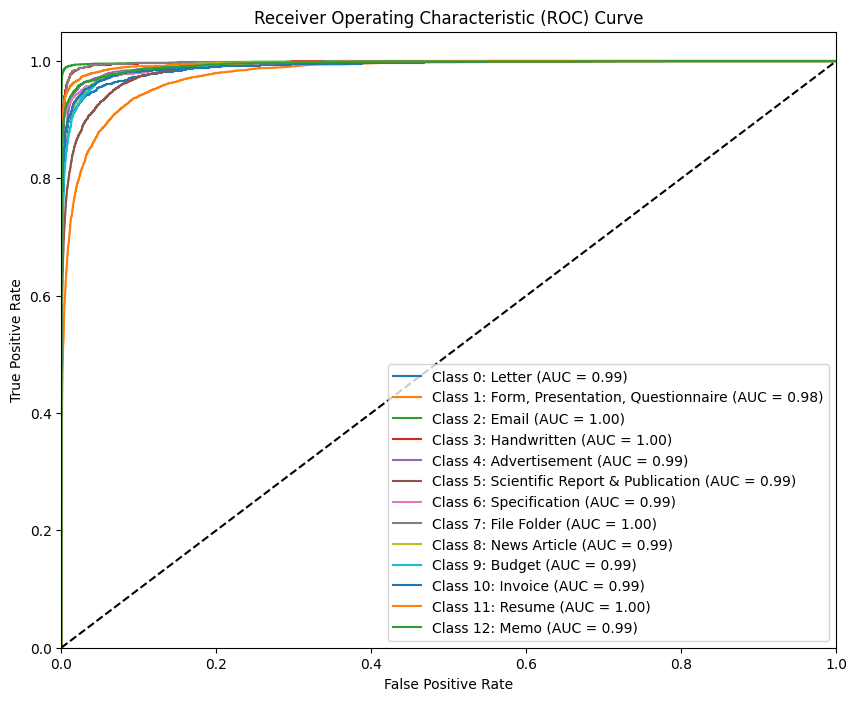

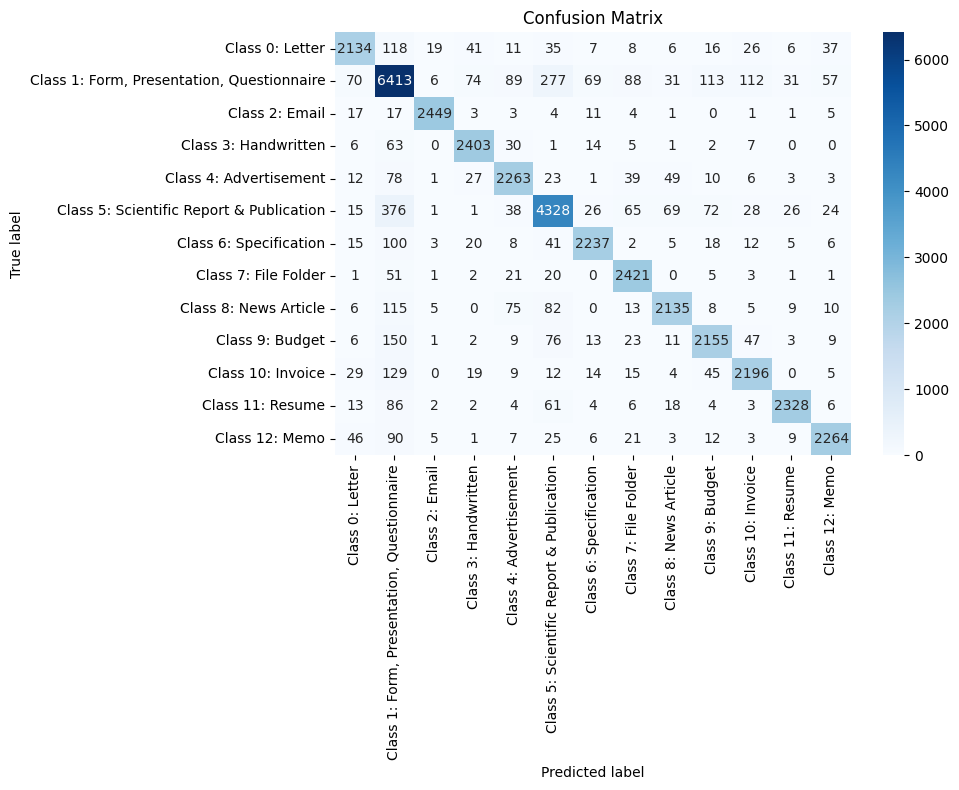

Classification Report (Console Output):
                                            precision    recall  f1-score   support

                           Class 0: Letter       0.90      0.87      0.88      2464
Class 1: Form, Presentation, Questionnaire       0.82      0.86      0.84      7430
                            Class 2: Email       0.98      0.97      0.98      2516
                      Class 3: Handwritten       0.93      0.95      0.94      2532
                    Class 4: Advertisement       0.88      0.90      0.89      2515
  Class 5: Scientific Report & Publication       0.87      0.85      0.86      5069
                    Class 6: Specification       0.93      0.90      0.92      2472
                      Class 7: File Folder       0.89      0.96      0.92      2527
                     Class 8: News Article       0.92      0.87      0.89      2463
                           Class 9: Budget       0.88      0.86      0.87      2505
                         Class 10: 

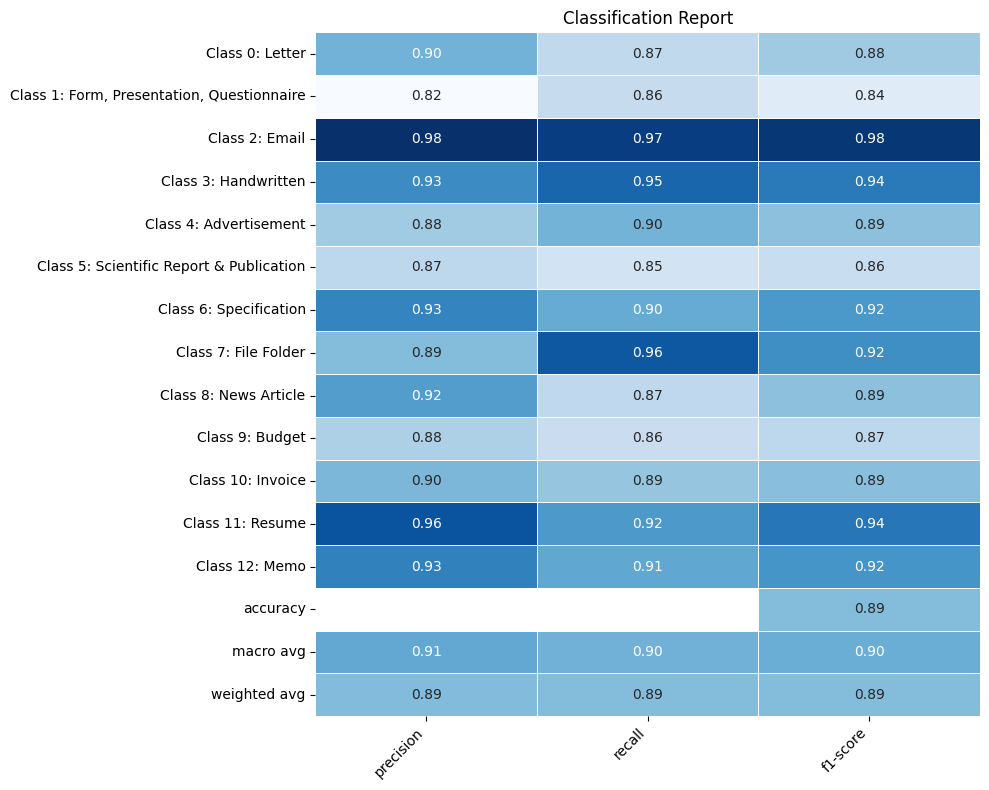

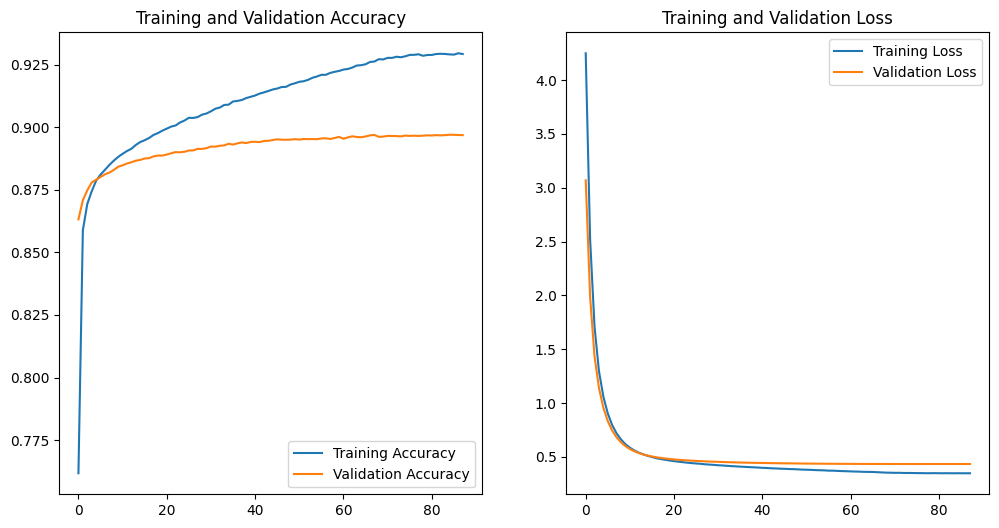

In [18]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import json
from keras.models import load_model

#-------------------------------------------------------------------------------
# Paramétrage de lancement
#-------------------------------------------------------------------------------
# Chemin vers le modèle sauvegardé et le dataset de test
model_path = "/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/multimodal_model_complet_group.keras"
test_dataset_tf_path = "/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/merged_test_dataset_final_group"
output_file_path = "/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/classification_multi_report_group.json"
history_path = '/content/drive/MyDrive/formation Datascientest/jul24_bds_extraction/ETAPE 3/models/history/training_multi_history_group.npy'
#-------------------------------------------------------------------------------
# Paramétrage de lancement
#-------------------------------------------------------------------------------

## Charger le modèle
# model = load_model(model_path, custom_objects={'TFBertLayer': TFBertLayer})
## Charger le dataset TensorFlow de test
test_dataset_tf = tf.data.Dataset.load(test_dataset_tf_path)

model = multimodal_model


# Évaluer le modèle
test_loss, test_acc = model.evaluate(test_dataset_tf)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Faire les prédictions sur le dataset de test
y_true = []  # Pour stocker les vraies étiquettes
y_pred_probs = []  # Pour stocker les probabilités prédites pour chaque classe

# Prédictions
predictions = model.predict(test_dataset_tf)
y_pred_probs = predictions

# Extraction des vraies labels
for _, labels in test_dataset_tf:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Convertir les étiquettes en format one-hot encoding (nécessaire pour ROC multi-classes)
n_classes = 13  # Le nombre de classes
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Calculer fprs, tprs, aucs pour chaque classe
fprs = {}
tprs = {}
aucs = {}
for i in range(n_classes):
    fprs[i], tprs[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    aucs[i] = auc(fprs[i], tprs[i])

# Les noms des labels associés aux classes avec le numéro
class_labels = ['Class 0: Letter', 'Class 1: Form, Presentation, Questionnaire', 'Class 2: Email', 'Class 3: Handwritten',
                'Class 4: Advertisement', 'Class 5: Scientific Report & Publication',
                'Class 6: Specification', 'Class 7: File Folder', 'Class 8: News Article',
                'Class 9: Budget', 'Class 10: Invoice', 'Class 11: Resume', 'Class 12: Memo']

# Tracer la courbe ROC avec les noms des labels et numéros de classes
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, roc_auc) in enumerate(zip(fprs.values(), tprs.values(), aucs.values())):
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# **Matrice de confusion**
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convertir les probabilités en classes
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# **Rapport de classification sous forme de tableau**
# 1. **Afficher le rapport de classification dans la console (sans `output_dict`)**
report_console = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report (Console Output):")
print(report_console)

# 2. **Sauvegarder le rapport de classification dans un fichier JSON ou CSV avec `output_dict=True`**
report_dict = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

# Sauvegarder en JSON
with open(output_file_path, 'w') as f:
    json.dump(report_dict, f, indent=4)

print(f"Classification report saved to {output_file_path}")

# 3. **Convertir le rapport de classification en DataFrame pour l'afficher
report_df = pd.DataFrame(report_dict).transpose()

# Supprimer les colonnes 'precision' et 'recall' pour la ligne 'accuracy'
report_df.loc['accuracy', ['precision', 'recall']] = [None, None]

# Affichage du rapport sous forme de tableau (plot)
plt.figure(figsize=(10, 8))
sns.heatmap(report_df.iloc[:, :-1], annot=True, fmt=".2f", cmap="Blues", cbar=False, linewidths=0.5)
plt.title('Classification Report')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# **Courbes d'apprentissage (si historique disponible)
try:
    history = np.load(history_path, allow_pickle=True).item()

    plt.figure(figsize=(12, 6))

    # Précision
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.savefig('learning_curves.png')
    plt.show()
except FileNotFoundError:
    print("Training history not found, skipping learning curves plot.")